# Install dependencies

In [46]:
!pip install ultralytics torch torchvision torchaudio
!pip install opencv-python-headless pandas matplotlib
!pip install pytesseract

# Verify GPU and Torch

In [4]:
import torch
print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

Torch version: 2.3.0+cu121
CUDA available: True


# Split dataset

In [5]:
import os
import shutil
import random

def split_dataset(source_folder, dest_folder, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Splits the synthetic_badges dataset into train, validation, and test sets.
    
    Args:
        source_folder (str): Path to 'synthetic_badges' dataset.
        dest_folder (str): Output folder where the split dataset will be stored.
        train_ratio (float): Proportion of images for training.
        val_ratio (float): Proportion of images for validation.
        test_ratio (float): Proportion of images for testing.
    """

    # Define paths
    image_dir = os.path.join(source_folder, "images")
    label_dir = os.path.join(source_folder, "annotations")

    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith((".jpg", ".png", ".jpeg"))]

    # Shuffle dataset
    random.shuffle(image_files)

    # Compute dataset splits
    total_images = len(image_files)
    train_split = int(total_images * train_ratio)
    val_split = train_split + int(total_images * val_ratio)

    train_files = image_files[:train_split]
    val_files = image_files[train_split:val_split]
    test_files = image_files[val_split:]

    # Create output folders
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(dest_folder, "images", split), exist_ok=True)
        os.makedirs(os.path.join(dest_folder, "labels", split), exist_ok=True)

    # Function to copy images and labels
    def move_files(file_list, split):
        for file in file_list:
            # Move image
            src_img = os.path.join(image_dir, file)
            dst_img = os.path.join(dest_folder, "images", split, file)
            shutil.copy(src_img, dst_img)

            # Move corresponding label (if exists)
            label_file = file.rsplit(".", 1)[0] + ".txt"
            src_label = os.path.join(label_dir, label_file)
            dst_label = os.path.join(dest_folder, "labels", split, label_file)
            if os.path.exists(src_label):
                shutil.copy(src_label, dst_label)

    # Move files to respective splits
    move_files(train_files, "train")
    move_files(val_files, "val")
    move_files(test_files, "test")

    print(f"Dataset successfully split into {dest_folder}")


In [6]:
split_dataset("/home/jovyan/computer-vision-demo/synthetic_badges", "/home/jovyan/computer-vision-demo/synthetic_badges_split")

Dataset successfully split into /home/jovyan/computer-vision-demo/synthetic_badges_split


# Train model

In [18]:
from ultralytics import YOLO

model = YOLO("yolo11n.pt")
results = model.train(data="/home/jovyan/computer-vision-demo/data.yaml", epochs=100, imgsz=640, device="cuda", batch=16)

New https://pypi.org/project/ultralytics/8.3.70 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.69 🚀 Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 14931MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/home/jovyan/computer-vision-demo/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=F

100%|██████████| 755k/755k [00:00<00:00, 107MB/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 23        [16, 19, 22]  1    431257  ultralytics.nn.modules.head.Detect           [3, [64, 128, 256]]           
YOLO11n summary: 319 layers, 2,590,425 parameters, 2,590,409 gradients, 6.4 GFLOPs

Transferred 448/499 items from pretrained weights
Freezing layer 'model.23.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...
AMP: checks passed ✅


train: Scanning /home/jovyan/computer-vision-demo/synthetic_badges_split/labels/train... 140 images, 0 backgrounds, 2 corrupt: 100%|██████████| 140/140 [00:00<00:00, 1330.32it/s]

train: WARNING ⚠️ /home/jovyan/computer-vision-demo/synthetic_badges_split/images/train/badge_156.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1725]
train: WARNING ⚠️ /home/jovyan/computer-vision-demo/synthetic_badges_split/images/train/badge_20.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1725]
train: New cache created: /home/jovyan/computer-vision-demo/synthetic_badges_split/labels/train.cache



val: Scanning /home/jovyan/computer-vision-demo/synthetic_badges_split/labels/val... 40 images, 0 backgrounds, 0 corrupt: 100%|██████████| 40/40 [00:00<00:00, 434.12it/s]

val: New cache created: /home/jovyan/computer-vision-demo/synthetic_badges_split/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.56G      3.484      4.264      2.684         68        640: 100%|██████████| 9/9 [00:04<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  50%|█████     | 1/2 [00:01<00:01,  1.75s/it]/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.00s/it]

                   all         40        120     0.0021      0.233    0.00176   0.000722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.58G      2.037      3.416      1.586         65        640: 100%|██████████| 9/9 [00:01<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.59it/s]

                   all         40        120    0.00735      0.733      0.153     0.0394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.59G      1.607      2.851      1.274         62        640: 100%|██████████| 9/9 [00:01<00:00,  6.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.13it/s]

                   all         40        120    0.00842      0.842      0.341      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.59G      1.463      2.419      1.203         62        640: 100%|██████████| 9/9 [00:01<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.39it/s]

                   all         40        120    0.00867      0.867      0.511      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.59G      1.482      2.139      1.191         75        640: 100%|██████████| 9/9 [00:01<00:00,  6.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.75it/s]

                   all         40        120    0.00882      0.883      0.549      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.59G      1.537      1.968      1.178         67        640: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.69it/s]

                   all         40        120      0.846      0.291      0.679      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.59G      1.451      1.862      1.138         63        640: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         40        120       0.82      0.611      0.753        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.59G      1.403      1.785      1.125         47        640: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.97it/s]

                   all         40        120      0.763      0.636      0.796      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.59G      1.387      1.625      1.115         70        640: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.08it/s]

                   all         40        120      0.828      0.577      0.798      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.59G      1.392       1.52      1.108         73        640: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         40        120      0.732      0.629      0.727      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.59G      1.363      1.516      1.104         79        640: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.52it/s]

                   all         40        120      0.659      0.666      0.727      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.59G      1.328      1.467      1.084         66        640: 100%|██████████| 9/9 [00:01<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.44it/s]

                   all         40        120      0.542       0.51      0.535      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.59G      1.288      1.429        1.1         76        640: 100%|██████████| 9/9 [00:01<00:00,  5.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.05it/s]

                   all         40        120      0.672      0.712      0.781      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.59G      1.214      1.346      1.081         71        640: 100%|██████████| 9/9 [00:01<00:00,  5.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.71it/s]

                   all         40        120      0.568      0.478      0.544      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.59G      1.255      1.335       1.07         74        640: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.14it/s]

                   all         40        120      0.574      0.392      0.406      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.59G      1.327      1.413      1.074         45        640: 100%|██████████| 9/9 [00:01<00:00,  6.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.83it/s]

                   all         40        120       0.73      0.638      0.772      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.59G      1.226      1.331       1.07         58        640: 100%|██████████| 9/9 [00:01<00:00,  6.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.86it/s]

                   all         40        120      0.825      0.717      0.849      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.59G      1.205      1.251       1.04         74        640: 100%|██████████| 9/9 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.36it/s]

                   all         40        120      0.849       0.76      0.837      0.589



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.59G      1.193      1.245      1.026         58        640: 100%|██████████| 9/9 [00:01<00:00,  6.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.35it/s]

                   all         40        120      0.842      0.611      0.771      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.59G       1.22       1.26      1.039         71        640: 100%|██████████| 9/9 [00:01<00:00,  6.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.72it/s]

                   all         40        120      0.834      0.649      0.771      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.59G      1.224      1.262      1.041         77        640: 100%|██████████| 9/9 [00:01<00:00,  6.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         40        120      0.823      0.691      0.782      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.59G      1.227      1.256      1.049         65        640: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         40        120       0.75      0.805      0.896      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.59G      1.227      1.281      1.071         54        640: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         40        120       0.88      0.746      0.875      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.59G      1.156      1.156      1.025         70        640: 100%|██████████| 9/9 [00:01<00:00,  5.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]

                   all         40        120      0.892      0.717       0.86      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.59G      1.153      1.163      1.027         81        640: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.23it/s]

                   all         40        120      0.882      0.726       0.87      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.59G      1.142      1.165      1.008         59        640: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.39it/s]

                   all         40        120      0.941      0.742      0.924      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.59G      1.151      1.199      1.014         62        640: 100%|██████████| 9/9 [00:01<00:00,  6.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.48it/s]

                   all         40        120      0.871        0.8      0.909      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.59G      1.127      1.155      1.019         50        640: 100%|██████████| 9/9 [00:01<00:00,  6.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.27it/s]

                   all         40        120      0.807      0.903      0.945       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.59G      1.059       1.09     0.9931         62        640: 100%|██████████| 9/9 [00:01<00:00,  6.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.46it/s]

                   all         40        120      0.911      0.908      0.962      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.59G      1.117      1.127     0.9996         55        640: 100%|██████████| 9/9 [00:01<00:00,  6.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.18it/s]

                   all         40        120      0.844      0.819      0.927      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.59G      1.085       1.07     0.9848         68        640: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.57it/s]

                   all         40        120      0.903      0.788      0.924      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.59G       1.07      1.092     0.9848         55        640: 100%|██████████| 9/9 [00:01<00:00,  6.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.20it/s]

                   all         40        120      0.774        0.9      0.939      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.59G      1.054      1.044     0.9809         64        640: 100%|██████████| 9/9 [00:01<00:00,  5.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.96it/s]

                   all         40        120      0.825      0.858       0.94      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.59G      1.029      1.031     0.9752         68        640: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.31it/s]

                   all         40        120      0.912      0.925      0.968       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.59G      1.029      1.006     0.9782         58        640: 100%|██████████| 9/9 [00:01<00:00,  5.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.26it/s]

                   all         40        120      0.928      0.941      0.965      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.59G      1.017      1.022     0.9727         60        640: 100%|██████████| 9/9 [00:01<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.83it/s]

                   all         40        120      0.837      0.857      0.943      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.59G      1.022     0.9548     0.9669         71        640: 100%|██████████| 9/9 [00:01<00:00,  5.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.61it/s]

                   all         40        120      0.852      0.828      0.936      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.59G     0.9885     0.9579     0.9631         67        640: 100%|██████████| 9/9 [00:01<00:00,  5.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.62it/s]

                   all         40        120      0.918      0.821      0.948      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.59G      1.022      0.955     0.9634         67        640: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.51it/s]

                   all         40        120      0.904      0.925      0.974      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.59G      1.007     0.9977     0.9671         71        640: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.10it/s]

                   all         40        120      0.914      0.788      0.939      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.59G      1.014     0.9426      0.964         69        640: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         40        120      0.934      0.787      0.943      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.59G      1.014     0.9702     0.9713         65        640: 100%|██████████| 9/9 [00:01<00:00,  6.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

                   all         40        120       0.98      0.848       0.97       0.71



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.59G      1.035     0.9871     0.9616         74        640: 100%|██████████| 9/9 [00:01<00:00,  6.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.29it/s]

                   all         40        120      0.882      0.889      0.946      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.59G      1.028     0.9419     0.9612         54        640: 100%|██████████| 9/9 [00:01<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.72it/s]

                   all         40        120      0.912      0.859      0.957      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.59G     0.9352     0.9234     0.9536         69        640: 100%|██████████| 9/9 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.19it/s]

                   all         40        120      0.883      0.938      0.963      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.59G     0.9752     0.9073     0.9611         62        640: 100%|██████████| 9/9 [00:01<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.86it/s]

                   all         40        120      0.892      0.943      0.976      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.59G     0.9744     0.8872      0.944         73        640: 100%|██████████| 9/9 [00:01<00:00,  6.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.26it/s]

                   all         40        120      0.846      0.891       0.94      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.59G     0.9733      0.915     0.9565         59        640: 100%|██████████| 9/9 [00:01<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.13it/s]

                   all         40        120      0.912      0.913      0.975      0.711



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.59G     0.9341     0.8511     0.9351         72        640: 100%|██████████| 9/9 [00:01<00:00,  6.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.96it/s]

                   all         40        120       0.92      0.947      0.974      0.728



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.59G      0.938     0.8911     0.9328         69        640: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.34it/s]

                   all         40        120      0.902      0.941      0.975      0.717



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.59G     0.9512     0.8552     0.9367         77        640: 100%|██████████| 9/9 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.67it/s]

                   all         40        120        0.9       0.94       0.98      0.719



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.59G     0.9212     0.8651     0.9329         71        640: 100%|██████████| 9/9 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]

                   all         40        120      0.952      0.932      0.988      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.58G     0.9519     0.8628     0.9384         70        640: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.19it/s]

                   all         40        120       0.92      0.967      0.986      0.738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.59G     0.9147     0.8362     0.9254         75        640: 100%|██████████| 9/9 [00:01<00:00,  6.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.29it/s]

                   all         40        120      0.921      0.946      0.979      0.718



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.59G     0.9405     0.8518     0.9311         58        640: 100%|██████████| 9/9 [00:01<00:00,  6.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.91it/s]

                   all         40        120      0.939      0.938      0.981      0.721



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.59G     0.9425      0.857     0.9427         73        640: 100%|██████████| 9/9 [00:01<00:00,  6.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.99it/s]

                   all         40        120      0.951      0.958      0.987      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.59G     0.9555     0.8483     0.9401         70        640: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.45it/s]

                   all         40        120      0.964      0.933       0.99      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.59G     0.8741     0.7872     0.9123         76        640: 100%|██████████| 9/9 [00:01<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.91it/s]

                   all         40        120      0.972      0.942      0.987      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.59G      0.917     0.8043     0.9253         64        640: 100%|██████████| 9/9 [00:01<00:00,  6.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.03it/s]

                   all         40        120      0.962       0.95      0.985      0.729



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.59G     0.9362     0.8129     0.9439         62        640: 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.03it/s]

                   all         40        120      0.949      0.873      0.965      0.706



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.59G     0.9165     0.8349     0.9406         66        640: 100%|██████████| 9/9 [00:01<00:00,  6.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

                   all         40        120      0.956      0.965      0.993      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.59G     0.8789     0.7809     0.9272         69        640: 100%|██████████| 9/9 [00:01<00:00,  6.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.75it/s]

                   all         40        120      0.973      0.961      0.991      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.59G     0.8912     0.7876      0.931         60        640: 100%|██████████| 9/9 [00:01<00:00,  5.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.67it/s]

                   all         40        120      0.961      0.967      0.984      0.723



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.59G     0.8644     0.7576     0.9113         57        640: 100%|██████████| 9/9 [00:01<00:00,  5.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.95it/s]

                   all         40        120      0.901       0.92      0.964      0.745



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.59G     0.8755     0.7752     0.9234         59        640: 100%|██████████| 9/9 [00:01<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.71it/s]

                   all         40        120      0.951      0.952      0.987      0.757



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.59G     0.8518     0.7991     0.9171         56        640: 100%|██████████| 9/9 [00:01<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.02it/s]

                   all         40        120      0.888       0.95      0.974      0.749



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.59G     0.8668     0.7937     0.9367         65        640: 100%|██████████| 9/9 [00:01<00:00,  5.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.12it/s]

                   all         40        120      0.943      0.969      0.985      0.747



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.59G     0.8563     0.7696     0.9193         65        640: 100%|██████████| 9/9 [00:01<00:00,  5.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

                   all         40        120      0.967      0.917      0.982       0.74



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.59G      0.821     0.7622     0.9057         70        640: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.99it/s]

                   all         40        120      0.954      0.974      0.989      0.766



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.59G     0.7939      0.727     0.9093         59        640: 100%|██████████| 9/9 [00:01<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.16it/s]

                   all         40        120      0.971      0.968      0.992       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.59G     0.8502     0.7564       0.91         57        640: 100%|██████████| 9/9 [00:01<00:00,  6.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

                   all         40        120      0.993      0.941      0.994      0.764



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.59G      0.817     0.7329      0.914         82        640: 100%|██████████| 9/9 [00:01<00:00,  6.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.42it/s]

                   all         40        120      0.938      0.976      0.986      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.59G     0.8324     0.7509     0.9082         60        640: 100%|██████████| 9/9 [00:01<00:00,  6.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.66it/s]

                   all         40        120      0.941      0.936      0.984       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.59G     0.7697     0.7016     0.8921         52        640: 100%|██████████| 9/9 [00:01<00:00,  6.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.84it/s]

                   all         40        120      0.938      0.979      0.986      0.771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.59G     0.7614     0.7115     0.8961         49        640: 100%|██████████| 9/9 [00:01<00:00,  6.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.57it/s]

                   all         40        120      0.956      0.975      0.991      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.59G     0.8082     0.6942     0.9028        101        640: 100%|██████████| 9/9 [00:01<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.88it/s]

                   all         40        120      0.923      0.942      0.983      0.743



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.59G     0.8059     0.7205     0.9138         70        640: 100%|██████████| 9/9 [00:01<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.15it/s]

                   all         40        120      0.979      0.944      0.989      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.59G     0.8358     0.7348     0.9062         68        640: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.23it/s]

                   all         40        120      0.991      0.997      0.995      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.59G     0.8047     0.7054     0.8938         72        640: 100%|██████████| 9/9 [00:01<00:00,  6.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.27it/s]

                   all         40        120      0.974      0.967      0.987      0.763



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.59G     0.7882     0.7067     0.8922         72        640: 100%|██████████| 9/9 [00:01<00:00,  6.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.28it/s]

                   all         40        120      0.991      0.983      0.994      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.59G     0.8098     0.7134     0.9097         69        640: 100%|██████████| 9/9 [00:01<00:00,  6.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]

                   all         40        120      0.979      0.975       0.99      0.777



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.59G      0.811     0.7398     0.9087         67        640: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.45it/s]

                   all         40        120      0.985      0.981      0.994      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.59G     0.8382      0.739     0.9106         59        640: 100%|██████████| 9/9 [00:01<00:00,  6.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.88it/s]

                   all         40        120      0.981      0.978      0.994      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.59G     0.7774      0.677     0.8986         65        640: 100%|██████████| 9/9 [00:01<00:00,  6.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.41it/s]

                   all         40        120      0.993      0.995      0.995      0.799



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.59G     0.7499     0.6909     0.8979         70        640: 100%|██████████| 9/9 [00:01<00:00,  6.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.35it/s]

                   all         40        120      0.973          1      0.992      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.59G     0.7593     0.6973     0.8985         75        640: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.03it/s]

                   all         40        120      0.977      0.983      0.993      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.59G     0.7784     0.6799     0.9026         69        640: 100%|██████████| 9/9 [00:01<00:00,  6.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  9.39it/s]

                   all         40        120      0.987       0.98      0.994      0.773



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.59G     0.7759     0.6961      0.903         56        640: 100%|██████████| 9/9 [00:01<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.59it/s]

                   all         40        120      0.975      0.975      0.992      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.59G     0.7277     0.6653     0.8837         68        640: 100%|██████████| 9/9 [00:01<00:00,  5.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.22it/s]

                   all         40        120      0.972      0.981       0.99      0.797



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.59G     0.7613     0.6755     0.8973         57        640: 100%|██████████| 9/9 [00:01<00:00,  6.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.97it/s]

                   all         40        120      0.991      0.977      0.992      0.811


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.55G     0.7433     0.8098     0.8893         30        640: 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.97it/s]

                   all         40        120      0.981      0.989      0.993      0.809



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.55G     0.7131     0.7446     0.8818         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.44it/s]

                   all         40        120      0.965      0.975      0.987      0.768



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.54G     0.7277     0.7404     0.8666         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.64it/s]

                   all         40        120      0.978      0.987      0.988      0.778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.56G     0.6845     0.7162     0.8865         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  6.69it/s]

                   all         40        120      0.964      0.992      0.989      0.783



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.55G     0.6824     0.6917     0.8727         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.57it/s]

                   all         40        120       0.99      0.994      0.995      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.55G     0.7052     0.6848     0.8844         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.78it/s]

                   all         40        120      0.992      0.998      0.995      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.54G     0.6559     0.6556      0.861         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.50it/s]

                   all         40        120      0.995          1      0.995      0.804



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.56G     0.6672     0.6735      0.867         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.94it/s]

                   all         40        120      0.978          1      0.994      0.795



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.55G      0.658     0.6537     0.8556         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.41it/s]

                   all         40        120      0.979          1      0.995      0.793



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.55G     0.6456      0.648     0.8772         30        640: 100%|██████████| 9/9 [00:01<00:00,  6.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  8.04it/s]

                   all         40        120      0.982          1      0.994      0.812



100 epochs completed in 0.067 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.69 🚀 Python-3.11.9 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 14931MiB)
YOLO11n summary (fused): 238 layers, 2,582,737 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.95it/s]


                   all         40        120      0.982          1      0.994      0.811
                  name         40         40      0.962          1      0.993      0.818
                 title         40         40      0.985          1      0.995      0.816
               company         40         40      0.998          1      0.995      0.798
Speed: 0.2ms preprocess, 1.4ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/detect/train2



image 1/1 /home/jovyan/computer-vision-demo/synthetic_badges_split/images/test/badge_174.jpg: 384x640 1 name, 1 title, 1 company, 10.5ms
Speed: 1.9ms preprocess, 10.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


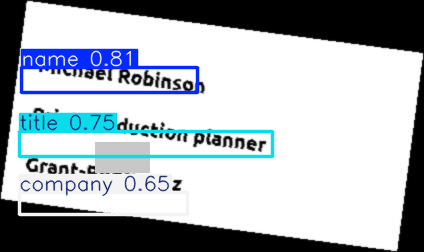

In [73]:
trained_model = YOLO("/home/jovyan/computer-vision-demo/runs/detect/train2/weights/best.pt")
predict_result = trained_model.predict("/home/jovyan/computer-vision-demo/synthetic_badges_split/images/test/badge_174.jpg")
for result in predict_result:
    result.show()

In [63]:
import pytesseract
import cv2
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw
from IPython.display import display
pytesseract.pytesseract.tesseract_cmd = '/opt/conda/bin/tesseract'
# Load YOLO Model
trained_model = YOLO("/home/jovyan/computer-vision-demo/runs/detect/train2/weights/best.pt")

# Load Image
image_path = "/home/jovyan/computer-vision-demo/synthetic_badges_split/images/test/badge_174.jpg"
image = Image.open(image_path)

# Run Object Detection
predict_result = trained_model.predict(image_path)

# Expansion factor for bounding box (10% increase)
expansion_factor = 0.1

for result in predict_result:
    boxes = result.boxes
    class_ids = boxes.cls.tolist()
    class_names = [trained_model.names[int(class_id)] for class_id in class_ids]
    xywh = boxes.xywh.tolist()

    draw = ImageDraw.Draw(image)

    for class_name, box in zip(class_names, xywh):
        if class_name == "name":
            x_center, y_center, width, height = box
            img_width, img_height = image.size

            # Convert YOLO format to bounding box coordinates (absolute pixel values)
            x_min = int((x_center - width / 2) * img_width)
            x_max = int((x_center + width / 2) * img_width)
            y_min = int((y_center - height / 2) * img_height)
            y_max = int((y_center + height / 2) * img_height)

            # Expand the bounding box
            expand_x = int(width * img_width * expansion_factor)
            expand_y = int(height * img_height * expansion_factor)

            x_min = max(0, min(img_width, x_min - expand_x))  # Ensure within bounds
            x_max = max(0, min(img_width, x_max + expand_x))
            y_min = max(0, min(img_height, y_min - expand_y))
            y_max = max(0, min(img_height, y_max + expand_y))
            # Ensure x_min < x_max and y_min < y_max
            if x_max <= x_min:
                x_max = x_min + 1
            if y_max <= y_min:
                y_max = y_min + 1
            # Draw the bounding box for visualization
            draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

            # Crop the expanded region
            cropped_image = image.crop((x_min, y_min, x_max, y_max))
            cropped_image.save("debug_cropped.jpg")  # Debug
            display(cropped_image)
            # Convert to OpenCV format for OCR
            cropped_cv = np.array(cropped_image)
            cropped_cv = cv2.cvtColor(cropped_cv, cv2.COLOR_RGB2GRAY)
            cropped_cv = cv2.threshold(cropped_cv, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

            detected_text = pytesseract.image_to_string(cropped_cv)
            print(f"Detected Name: {detected_text}")



image 1/1 /home/jovyan/computer-vision-demo/synthetic_badges_split/images/test/badge_174.jpg: 384x640 1 name, 1 title, 1 company, 8.6ms
Speed: 1.7ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


Detected Name: 


In [52]:
!conda install -c conda-forge pytesseract tesseract -y

Retrieving notices: ...working... done
Channels:
 - conda-forge
Platform: linux-64
Solving environment: done


==> WARNING: A newer version of conda exists. <==
    current version: 24.5.0
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - pytesseract
    - tesseract


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.12.14 |       hbcca054_0         153 KB  conda-forge
    cairo-1.18.0               |       hebfffa5_3         961 KB  conda-forge
    certifi-2024.12.14         |     pyhd8ed1ab_0         158 KB  conda-forge
    expat-2.6.4                |       h5888daf_0         135 KB  conda-forge
    glib-2.82.2                |       h07242d1_1         588 KB  conda-forge
    glib-tools-2.82.2          |       h4833e2c_1

# Test Mateo name

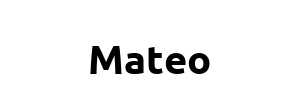

Detected Text: Mateo


In [70]:
import pytesseract
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont

# Set Tesseract Path
pytesseract.pytesseract.tesseract_cmd = '/opt/conda/bin/tesseract'

# Create a blank white image
img_width, img_height = 300, 100
image = Image.new('RGB', (img_width, img_height), color='white')

# Draw text on the image
draw = ImageDraw.Draw(image)
font_path = '/home/jovyan/computer-vision-demo/Ubuntu-Bold.ttf'
font_size = 40

try:
    font = ImageFont.truetype(font_path, font_size)  # Convert to ImageFont object
except IOError:
    print("Font file not found, using default font.")
    font = ImageFont.load_default()

text = "Mateo"

# Get text bounding box
text_bbox = draw.textbbox((0, 0), text, font=font)
text_width, text_height = text_bbox[2] - text_bbox[0], text_bbox[3] - text_bbox[1]

# Center the text
text_x = (img_width - text_width) // 2
text_y = (img_height - text_height) // 2
draw.text((text_x, text_y), text, fill='black', font=font)

# Save and display the image
image.save("test_mateo.jpg")
image.show()

# Convert image to OpenCV format
image_cv = np.array(image)
image_cv = cv2.cvtColor(image_cv, cv2.COLOR_RGB2GRAY)
detected_text = pytesseract.image_to_string(image_cv, config="--psm 6").strip()
print(f"Detected Text: {detected_text}")


# Testing cropped

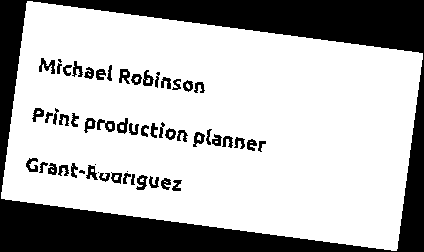

Detected Text: Michaet Robinson
Pring Production Planner
Grant-Ruatigues



In [108]:
import pytesseract
import cv2
import numpy as np
from PIL import Image, ImageFilter
from IPython.display import display

# Load image
image_path = "/home/jovyan/computer-vision-demo/synthetic_badges_split/images/test/badge_174.jpg"
image = Image.open(image_path)

# Convert image to OpenCV format for better preprocessing
debug_image = np.array(image)
debug_image = cv2.cvtColor(debug_image, cv2.COLOR_RGB2BGR)

# 1. Denoising (if noise was added during augmentation)
debug_image_denoised = cv2.fastNlMeansDenoisingColored(debug_image, None, 10, 10, 7, 21)

# 2. Sharpening (if blur was added)
kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
debug_image_sharpened = cv2.filter2D(debug_image_denoised, -1, kernel)

# 3. Convert to grayscale
debug_image_gray = cv2.cvtColor(debug_image_sharpened, cv2.COLOR_BGR2GRAY)

# 4. Thresholding for better contrast
_, debug_image_binary = cv2.threshold(debug_image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Show preprocessed image
preprocessed_image = Image.fromarray(debug_image_binary)
display(preprocessed_image)

# Use Tesseract for OCR
detected_text = pytesseract.image_to_string(debug_image_binary, config="--psm 6")
print(f"Detected Text: {detected_text}")



In [ ]:
pip freeze | grep kfp
